# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- mettre au propre les commentaires de l'étape 3

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.8
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [6]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [7]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(549, 1080), (868, 1080), (868, 604), (549, 604)], [(1063, 1080), (1369, 1080), (1369, 616), (1063, 616)], [(0, 1080), (391, 1080), (391, 514), (0, 514)]]
Centroid de la goal area : [1630.   572.5]
Vecteur direction du robot : 96 -6
Centroid du robot : [592 499]


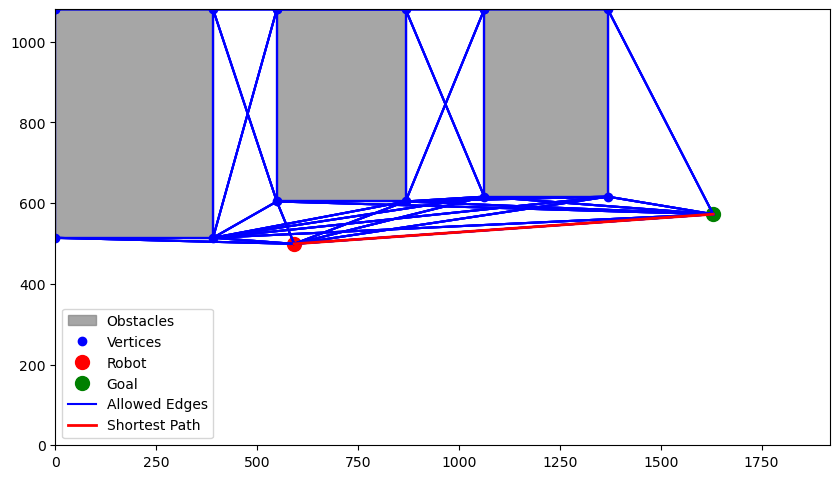

In [8]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration :  1
Kalman:  x:  32.0 , y:  26.0 , angle:  -0.06241880999595735
Rotation state:
Robot angle:  [-0.06241881] , Goal angle:  [0.07130746] , Rotation to achieve:  [0.13372627]
Iteration :  2
Kalman:  x:  32.17327113048349 , y:  25.98917055434478 , angle:  -0.061383138550525795
Rotation state:
Robot angle:  [-0.06138314] , Goal angle:  [0.07172102] , Rotation to achieve:  [0.13310416]
Iteration :  3
Kalman:  x:  32.49700064152725 , y:  25.966516681144824 , angle:  -0.03663073978078274
Rotation state:
Robot angle:  [-0.03663074] , Goal angle:  [0.07254392] , Rotation to achieve:  [0.10917466]
Iteration :  4
Kalman:  x:  32.616234486151974 , y:  25.96091567088272 , angle:  0.02556818359730486
Rotation state:
Robot angle:  [0.02556818] , Goal angle:  [0.07280015] , Rotation to achieve:  [0.04723196]
Iteration :  5
Kalman:  x:  32.625594412440186 , y:  25.961434345523752 , angle:  0.04831906237150504
Translation state:
Error =  [55.52148059]
Iteration :  6
Kalman:  x:  32.6398940979

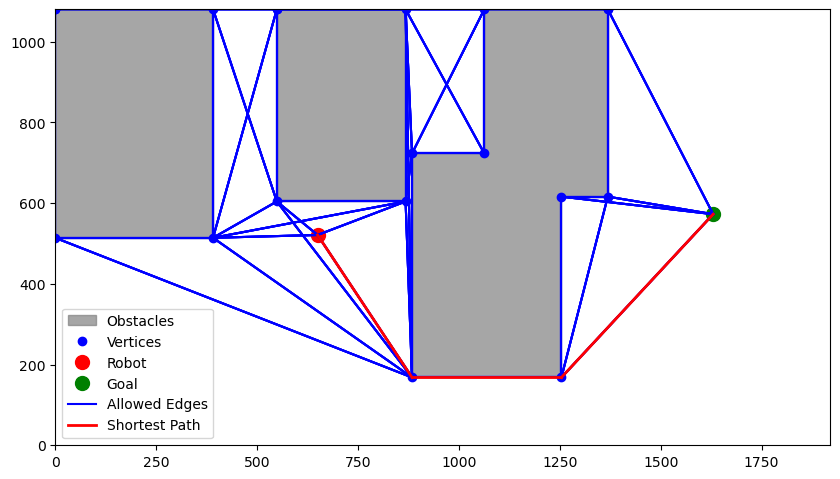

centroid camera:  (35, 28)
glob nav path : [(47, 9), (67, 9), (88, 30)]
Iteration :  22
Kalman:  x:  35.00066112142693 , y:  28.000063551575906 , angle:  9.431578751867287e-05
Rotation state:
Robot angle:  [9.43157875e-05] , Goal angle:  [-1.00750645] , Rotation to achieve:  [-1.00760077]
Iteration :  23
Kalman:  x:  34.06621920596104 , y:  27.999978801563305 , angle:  -0.0012952796216087032
Rotation state:
Robot angle:  [-0.00129528] , Goal angle:  [-0.97312335] , Rotation to achieve:  [-0.97182807]
Iteration :  24
Kalman:  x:  33.299074190966934 , y:  27.9977351691404 , angle:  -0.01497196955161912
Rotation state:
Robot angle:  [-0.01497197] , Goal angle:  [-0.94599176] , Rotation to achieve:  [-0.93101979]
Iteration :  25
Kalman:  x:  32.90171661474068 , y:  27.997919530790625 , angle:  -0.06452743657093696
Rotation state:
Robot angle:  [-0.06452744] , Goal angle:  [-0.93237289] , Rotation to achieve:  [-0.86784545]
Iteration :  26
Kalman:  x:  32.74804826531446 , y:  28.00771514535

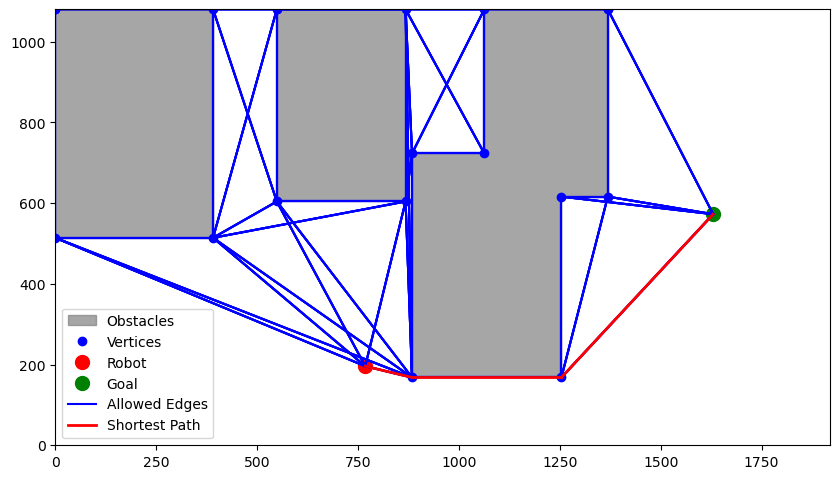

centroid camera:  (41, 10)
glob nav path : [(47, 9), (67, 9), (88, 30)]
Iteration :  62
Kalman:  x:  41.0002622393871 , y:  9.999478494166572 , angle:  -1.1440271084811249
Rotation state:
Robot angle:  [-1.14402711] , Goal angle:  [-0.16507119] , Rotation to achieve:  [0.97895592]
Iteration :  63
Kalman:  x:  41.08331288533388 , y:  9.81682718786158 , angle:  -1.1377331105098136
Rotation state:
Robot angle:  [-1.13773311] , Goal angle:  [-0.13718765] , Rotation to achieve:  [1.00054546]
Iteration :  64
Kalman:  x:  41.142451846308546 , y:  9.687298161276944 , angle:  -1.114039130626518
Rotation state:
Robot angle:  [-1.11403913] , Goal angle:  [-0.1168014] , Rotation to achieve:  [0.99723773]
Iteration :  65
Kalman:  x:  41.172209825466076 , y:  9.625309536198621 , angle:  -1.058530023651939
Rotation state:
Robot angle:  [-1.05853002] , Goal angle:  [-0.10688893] , Rotation to achieve:  [0.95164109]
Iteration :  66
Kalman:  x:  41.189573642405506 , y:  9.594389386626338 , angle:  -0.98

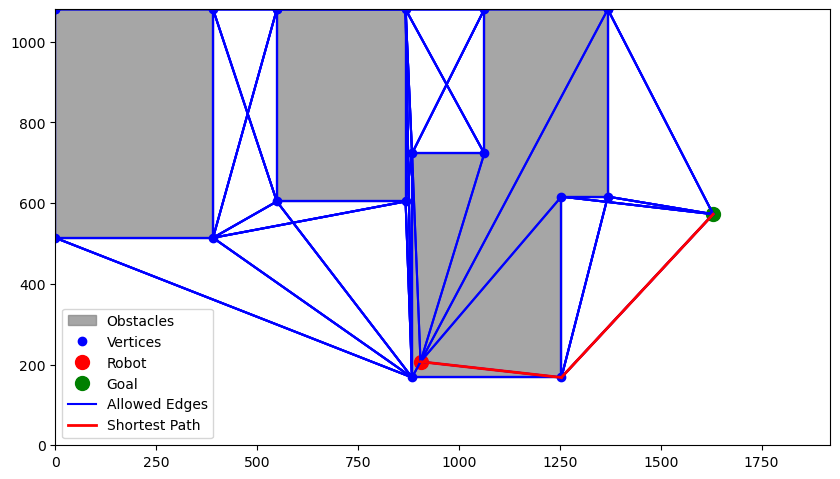

centroid camera:  (48, 11)
glob nav path : [(67, 9), (88, 30)]
Iteration :  86
Kalman:  x:  48.00044266862544 , y:  11.00005838874888 , angle:  -0.07838825915488681
Rotation state:
Robot angle:  [-0.07838826] , Goal angle:  [-0.1048824] , Rotation to achieve:  [-0.02649414]
Iteration :  87
Kalman:  x:  48.07246162403638 , y:  10.994400435691915 , angle:  -0.07981379021008012
Translation state:
Error =  [19.03232361]
Iteration :  88
Kalman:  x:  48.24532130052793 , y:  10.980550941033128 , angle:  -0.08178388267569114
Translation state:
Error =  [18.85896485]
Iteration :  89
Kalman:  x:  48.58111918285951 , y:  10.953189215062316 , angle:  -0.08302746819612156
Translation state:
Error =  [18.52215211]
Iteration :  90
Kalman:  x:  49.32389618710141 , y:  10.892599963589735 , angle:  -0.08977406505515526
Translation state:
Error =  [17.77713646]
Iteration :  91
Kalman:  x:  50.271482236824944 , y:  10.807369060219479 , angle:  -0.09996367801010105
Translation state:
Error =  [16.82586965]

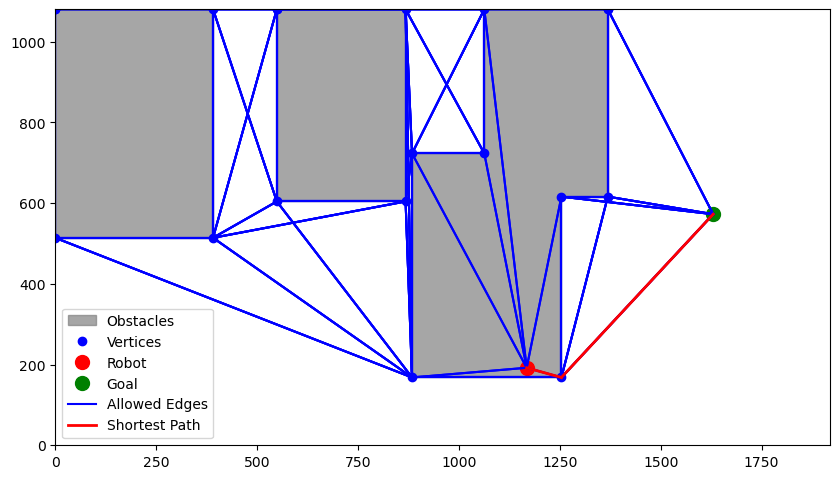

centroid camera:  (63, 10)
glob nav path : [(88, 30)]
Iteration :  108
Kalman:  x:  63.00067739704239 , y:  9.999897753016917 , angle:  -0.1172817904208608
Rotation state:
Robot angle:  [-0.11728179] , Goal angle:  [0.67475665] , Rotation to achieve:  [0.79203844]
Iteration :  109
Kalman:  x:  63.20704398113594 , y:  9.975582878153492 , angle:  -0.11112524294007937
Rotation state:
Robot angle:  [-0.11112524] , Goal angle:  [0.67939763] , Rotation to achieve:  [0.79052287]
Iteration :  110
Kalman:  x:  63.39497313255486 , y:  9.953623611933708 , angle:  -0.08768338056073678
Rotation state:
Robot angle:  [-0.08768338] , Goal angle:  [0.68365645] , Rotation to achieve:  [0.77133983]
Iteration :  111
Kalman:  x:  63.49584295549821 , y:  9.943967665686875 , angle:  -0.030867051949020327
Rotation state:
Robot angle:  [-0.03086705] , Goal angle:  [0.68590492] , Rotation to achieve:  [0.71677197]
Iteration :  112
Kalman:  x:  63.54341349898174 , y:  9.942587732430798 , angle:  0.04676123752452

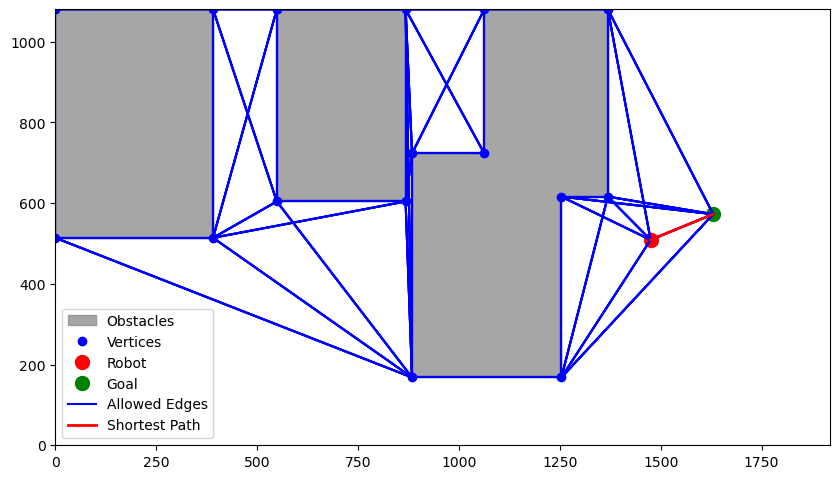

centroid camera:  (79, 27)
glob nav path : [(88, 30)]
Iteration :  153
Kalman:  x:  79.0005524618278 , y:  27.000506256130798 , angle:  0.700987395467872
Rotation state:
Robot angle:  [0.7009874] , Goal angle:  [0.32171834] , Rotation to achieve:  [-0.37926905]
Iteration :  154
Kalman:  x:  79.05004316383476 , y:  27.042274863345224 , angle:  0.7080356572272497
Rotation state:
Robot angle:  [0.70803566] , Goal angle:  [0.31917466] , Rotation to achieve:  [-0.388861]
Iteration :  155
Kalman:  x:  79.0947651945429 , y:  27.08120210310891 , angle:  0.6965453565808626
Rotation state:
Robot angle:  [0.69654536] , Goal angle:  [0.31672803] , Rotation to achieve:  [-0.37981732]
Iteration :  156
Kalman:  x:  79.11033282280769 , y:  27.09468501513887 , angle:  0.6448441390123716
Rotation state:
Robot angle:  [0.64484414] , Goal angle:  [0.31587653] , Rotation to achieve:  [-0.32896761]
Iteration :  157
Kalman:  x:  79.11093039503878 , y:  27.09509220500223 , angle:  0.5674910087722298
Rotation 

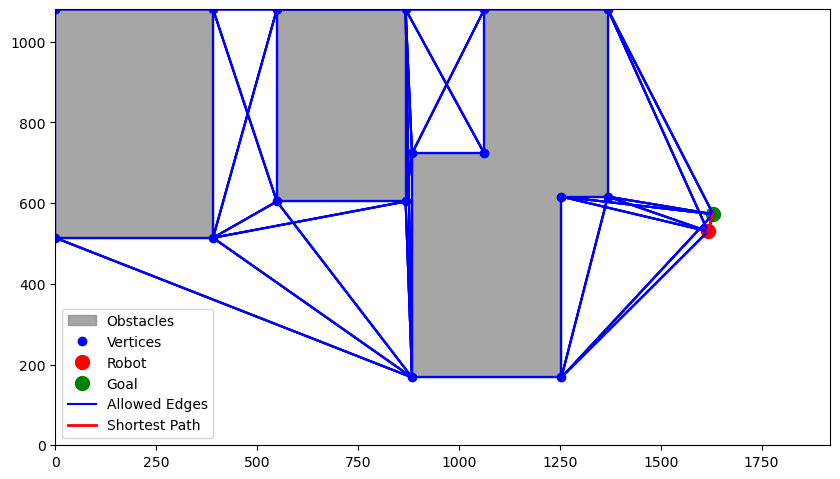

centroid camera:  (87, 28)
glob nav path : [(88, 30)]
Iteration :  173
Kalman:  x:  87.00064932232279 , y:  28.000205429429556 , angle:  0.20008601566661632
Rotation state:
Robot angle:  [0.20008602] , Goal angle:  [1.10736741] , Rotation to achieve:  [0.90728139]
Iteration :  174
Kalman:  x:  87.65713740931598 , y:  28.13333373806244 , angle:  0.19622920453530224
Rotation state:
Robot angle:  [0.1962292] , Goal angle:  [1.38914464] , Rotation to achieve:  [1.19291543]
Iteration :  175
Kalman:  x:  88.1852164154767 , y:  28.233749210460573 , angle:  0.21496472876054623
Rotation state:
Robot angle:  [0.21496473] , Goal angle:  [1.67527863] , Rotation to achieve:  [1.4603139]
Iteration :  176
Kalman:  x:  88.3752130622109 , y:  28.272728175806655 , angle:  0.27213828728939377
Rotation state:
Robot angle:  [0.27213829] , Goal angle:  [1.78470177] , Rotation to achieve:  [1.51256348]
Iteration :  177
Kalman:  x:  88.44483951595701 , y:  28.292270787006437 , angle:  0.35133238645919723
Rota

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : -32 85
Centroid du robot : [1573  596]


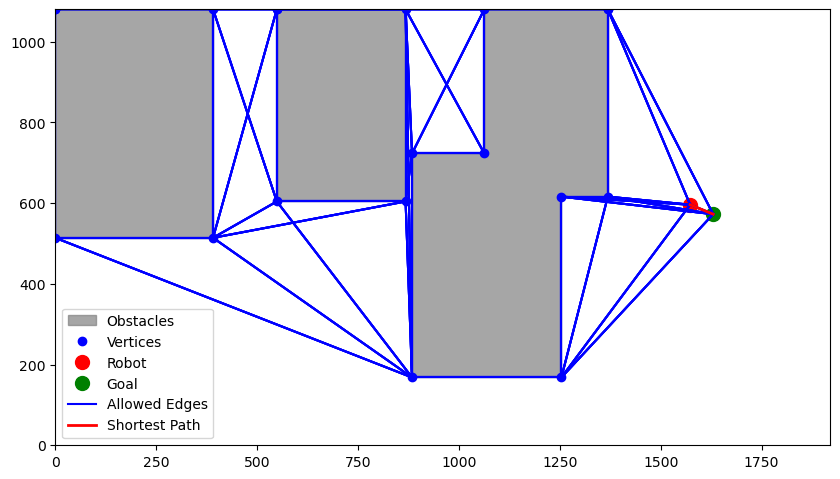

centroid camera:  (85, 32)
glob nav path : []
Iteration :  199
Thymio arrived in the goal area, congratulations!


In [9]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

old_time = 0.0
iter = 0


while(True):
    
    if iter == 0:                   
        old_time = time.time()
        
    dt = time.time() - old_time     # get time difference for Kalman 
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter = iter + 1
    print("Iteration : ", iter)

    
    # Check if the robot is arrived to the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        break
    
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    
    # Prox sensors detect something, we call the local navigation
    if detected == True:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE

        
    #CA SERT A QUOI RAPH? A mettre dans une fonction?
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        # Compute the difference between the robot direction and the direction of the goal
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], 
                           intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        # Define the turning orientation
        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise

        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise

        # Check the orientation of the robot
        if(abs(angle) < ROT_ACCURACY):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue
        
        
        
    elif global_state == TRANSLATION_STATE:
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]
        
        # Check if the robot achieve the intermediate goal
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        # Check if the robot orientation change a lot from its goal direction
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
        
    elif global_state == CAMERA_STATE:
        print("Camera state:")
        robot_centroid = [0,0]
        
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        
        # Convert in centimeter for the Kalman filter
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        intermediate_goals = shortest_path
        # Delete the first goal because it's the robot position
        intermediate_goals.pop(0)
        
        # Check if the robot achieve the next goal, if yes it can target the next one
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("glob nav path :", intermediate_goals)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("Local avoidance state:")
        
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        # Check if we detect an already known obstacle or an other one
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        # Add the new obstacle to the list
        obstacles.append(Object)
        prox_sensors_bool = True
        
        # The robot is backwarding in order to avoid the obstacle
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [10]:
await stop_robot()       #A RETIRER LORS DU RENDU, CAR NON UTILE